# Continental Scale Soil Organic Carbon Estimation via a Multisource Data Fusion Approach

A hybrid approach to predict Soil Organic Carbon (SOC) levels by combining measurements from a low-cost infrared device with open geospatial data through a multisource CNN-ML regression model is presented. The proposed approach leverages a CNN to extract features from spectral data obtained by the NeoSpectra sensor. Subsequently, these features are integrated into a ML model (both RF and XGBoost have been tested), which also incorporates geospatial covariates (VIF has been implemented to assess the multicollinearity) to enhance SOC prediction accuracy. The efficacy of this methodology is assessed using a diverse mineral soil database (~1500) from various locations within the context of the Soil Spectroscopy 4 Global Good modeling challenge.

In [1]:
!pip install seaborn matplotlib pandas numpy statsmodels cartopy geopandas hyperopt tensorflow keras scikit-learn scipy xgboost scikit-optimize tqdm joblib
print('All necessary packages are installed! :)')

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------  7.9/8.1 MB 37.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 35.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ------------------- -------------------- 4.7/9.8 MB 22.0 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 34.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 11.0/11.0 MB 97.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 28.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---- ----------------------------------- 16.8/150.0 MB 8

In [43]:
# Standard imports
import os
import re
import csv
import random
import zipfile
from math import sqrt

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

# Statistical modeling and analysis
import statsmodels.api as sm
from scipy.stats import iqr , gaussian_kde

# Geospatial packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

# Deep Learning and related utilities
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Hyperparameter tuning
from hyperopt import fmin, tpe, hp, Trials

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Other Machine Learning packages
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from tqdm import tqdm
from joblib import dump

## Spet 0: Data preprocessing

In [5]:
#import train spectral Neospectra's data
spec_train_data = pd.read_csv("train.csv")
spec_train_data.head()

,sample_id,soc_perc_log1p,1350,1352,1354,1356,1358,1360,1362,1364,...,2532,2534,2536,2538,2540,2542,2544,2546,2548,2550
0,S11580,0.41871,0.24450,0.24451,0.24439,0.24411,0.24366,0.24311,0.24256,0.24209,...,0.13869,0.13821,0.13773,0.13724,0.13674,0.13624,0.13573,0.13521,0.13469,0.13416
1,S56448,0.13976,0.62000,0.61932,0.61860,0.61787,0.61715,0.61647,0.61586,0.61535,...,0.39450,0.39372,0.39292,0.39209,0.39123,0.39033,0.38939,0.38840,0.38736,0.38624
2,S44770,0.94001,0.55591,0.55676,0.55751,0.55814,0.55867,0.55914,0.55962,0.56015,...,0.55878,0.55823,0.55769,0.55716,0.55664,0.55612,0.55562,0.55512,0.55463,0.55414
3,S26987,0.63954,0.52688,0.52784,0.52876,0.52958,0.53026,0.53082,0.53130,0.53175,...,0.50727,0.50666,0.50606,0.50547,0.50490,0.50434,0.50379,0.50326,0.50274,0.50223
4,S76345,0.32208,0.66920,0.66972,0.67020,0.67061,0.67094,0.67122,0.67148,0.67175,...,0.59059,0.58985,0.58912,0.58840,0.58768,0.58697,0.58627,0.58557,0.58489,0.58420


In [6]:
#import test spectral Neospectra's data
spec_test_data = pd.read_csv("test.csv")
spec_test_data.head()

,sample_id,soc_perc_log1p,1350,1352,1354,1356,1358,1360,1362,1364,...,2532,2534,2536,2538,2540,2542,2544,2546,2548,2550
0,S4824,1.14708,0.50709,0.50734,0.50765,0.50807,0.50864,0.50934,0.51015,0.51099,...,0.54061,0.54051,0.54044,0.54041,0.54042,0.54048,0.54061,0.54081,0.54109,0.54145
1,S2580,1.17000,0.52956,0.53018,0.53060,0.53087,0.53102,0.53118,0.53144,0.53188,...,0.52157,0.52153,0.52149,0.52143,0.52136,0.52126,0.52113,0.52096,0.52076,0.52050
2,S7750,1.20627,0.51638,0.51644,0.51669,0.51718,0.51788,0.51872,0.51958,0.52034,...,0.52747,0.52736,0.52725,0.52715,0.52706,0.52699,0.52693,0.52688,0.52685,0.52684
3,S2136,1.04977,0.49325,0.49356,0.49407,0.49476,0.49556,0.49636,0.49705,0.49757,...,0.51100,0.51085,0.51071,0.51058,0.51049,0.51042,0.51039,0.51040,0.51046,0.51056
4,S3002,1.15531,0.49907,0.49956,0.50028,0.50112,0.50195,0.50262,0.50305,0.50324,...,0.52176,0.52160,0.52146,0.52134,0.52127,0.52124,0.52126,0.52135,0.52151,0.52176


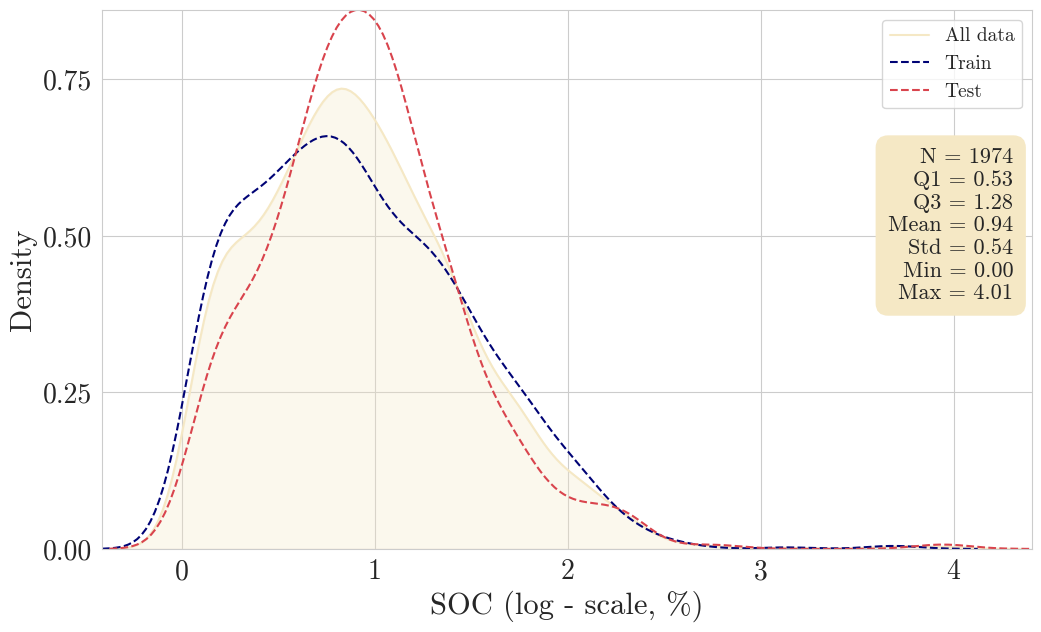

In [7]:
# Define folder paths
output_dir = 'outputs'
plot_dir = os.path.join(output_dir, 'plots')
os.makedirs(plot_dir, exist_ok=True)

# Update global font settings
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']

# Define custom font properties for explicit use
custom_font = fm.FontProperties(family='cmr10', size=20)

# Set Seaborn style and color palette
sns.set_palette(['#000375', '#D9444D', '#F5E8C5'])
sns.set_style("whitegrid")

# Reset indices of training and test data
spec_train_data_reset = spec_train_data['soc_perc_log1p'].reset_index(drop=True)
spec_test_data_reset = spec_test_data['soc_perc_log1p'].reset_index(drop=True)

# Combine all data
all_data = pd.concat([spec_train_data_reset, spec_test_data_reset])
all_data = all_data.reset_index(drop=True)

plt.figure(figsize=(12, 7))

# Get KDE curve data for all data
kde_all = sns.kdeplot(all_data, label='All data', color='#F5E8C5')
x_all, y_all = kde_all.get_lines()[0].get_data()

# Fill area under the "All Data" KDE curve
plt.fill_between(x_all, y_all, color='#F5E8C5', alpha=0.3)

# Plot KDEs for train and test sets
sns.kdeplot(spec_train_data_reset, label='Train', linestyle='--', color='#000375')
sns.kdeplot(spec_test_data_reset, label='Test', linestyle='--', color='#D9444D')

# Axis labels
plt.xlabel('SOC (log - scale, %)', fontproperties=custom_font, fontsize=22)
plt.ylabel('Density', fontproperties=custom_font, fontsize=22)

# **Set y-axis tick labels manually**
yticks_values = [0, 0.25, 0.5, 0.75, 1]
plt.yticks(yticks_values, [f"{tick:.2f}" for tick in yticks_values], fontproperties=custom_font)

# Apply custom font to x-ticks
plt.xticks(fontproperties=custom_font)

# Increase legend size
plt.legend(fontsize=24, prop={'family': 'cmr10'})

# Compute absolute values of statistics
n_value = len(all_data)
q1_value = abs(all_data.quantile(0.25))
q3_value = abs(all_data.quantile(0.75))
mean_value = abs(all_data.mean())
std_value = abs(all_data.std())
min_value = abs(all_data.min())
max_value = abs(all_data.max())

# Format the statistics text
stats_text = (
    'N = {}\nQ1 = {:.2f}\nQ3 = {:.2f}\nMean = {:.2f}\nStd = {:.2f}\nMin = {:.2f}\nMax = {:.2f}'
    .format(n_value, q1_value, q3_value, mean_value, std_value, min_value, max_value)
)

# Text box properties
bbox_props = dict(boxstyle="round,pad=0.5", fc="#F5E8C5", ec="#F5E8C5", lw=2)

# Add statistics text box
plt.text(0.98, 0.6, stats_text, transform=plt.gca().transAxes, fontsize=16, 
         verticalalignment='center', horizontalalignment='right', 
         bbox=bbox_props, fontproperties=custom_font)

# Adjust plot limits and remove extra whitespace
plt.autoscale(enable=True, axis='both', tight=True)

# Save plot without extra margins
plt.savefig(os.path.join(plot_dir, 'density.png'), bbox_inches='tight')
plt.show()


# Regression analysis

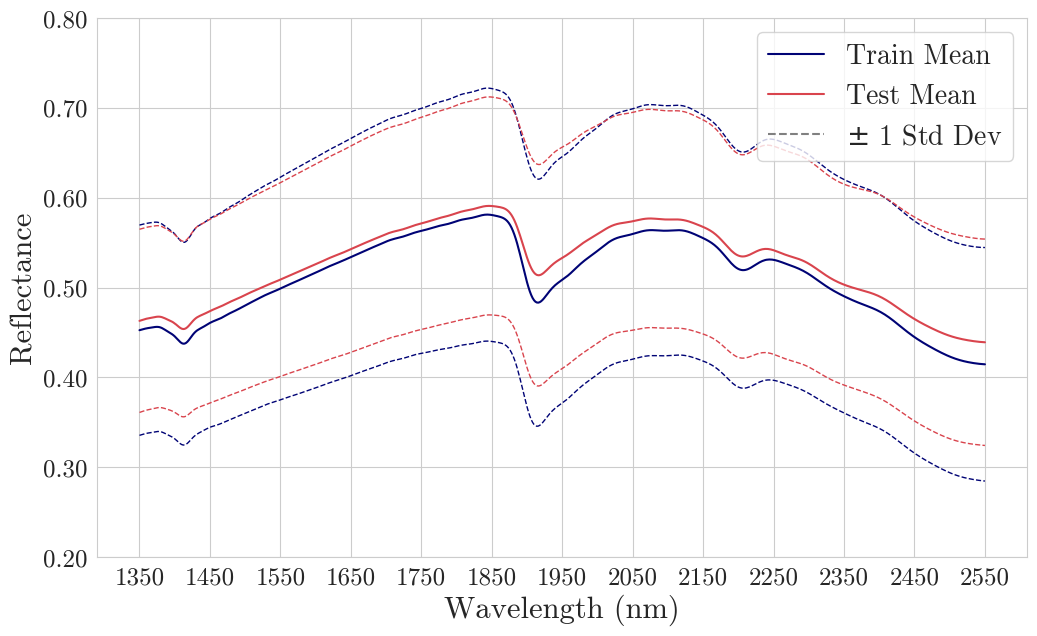

In [8]:
# Set font size
plt.rcParams.update({'font.size': 13})

# Set font family to serif and font name to cmr10 (Computer Modern Serif)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']

# Enable mathtext mode globally
plt.rcParams['axes.formatter.use_mathtext'] = True

# Assuming you have already defined spec_train_data and spec_test_data

# Extract spectral values from column 3 till the end
train_spectral_values = spec_train_data.iloc[:, 2:].values
test_spectral_values = spec_test_data.iloc[:, 2:].values

# Calculate the mean and std of each dataset
train_mean = train_spectral_values.mean(axis=0)
test_mean = test_spectral_values.mean(axis=0)
train_std = train_spectral_values.std(axis=0)
test_std = test_spectral_values.std(axis=0)

# Create plot
plt.figure(figsize=(12,7))

# Plot mean values
plt.plot(train_mean, label='Train Mean', color='#000375')
plt.plot(test_mean, label='Test Mean', color='#D9444D')

# Plot dashed lines representing ± one standard deviation for both train and test datasets
plt.plot(train_mean + train_std, linestyle='--', linewidth=1, color='#000375')
plt.plot(train_mean - train_std, linestyle='--', linewidth=1, color='#000375')
plt.plot(test_mean + test_std, linestyle='--', linewidth=1, color='#D9444D')
plt.plot(test_mean - test_std, linestyle='--', linewidth=1, color='#D9444D')

# Adding legend for dataset colors (MDPI-compliant minus sign)
plt.plot([], [], linestyle='--', color='gray', label=r'$\pm$ 1 Std Dev')

plt.xlabel('Wavelength (nm)', fontsize=22)
plt.ylabel('Reflectance', fontsize=22)
plt.grid(True)

# Calculate the number of ticks for the x-axis
num_ticks = len(train_mean)
# Calculate the wavelength values for the ticks with a step size of 100
wavelength_ticks = range(1350, 2551, 100)

plt.xticks(range(0, num_ticks, int(num_ticks / (len(wavelength_ticks) - 1))), wavelength_ticks, fontsize=18)  # Adjust the ticks and labels
plt.yticks(fontsize=18)  # Set y-axis tick font size

# Adjust legend location and font size
plt.legend(loc='upper right', fontsize=20)

# Set y-axis limits from 0.25 to 0.75
plt.ylim(0.25, 0.75)

# **Ensure MDPI-compliant minus sign for y-tick labels**
ax = plt.gca()
yticks_values = ax.get_yticks()  # Get current tick positions
ax.set_yticks(yticks_values)  # Ensure fixed tick positions
ax.set_yticklabels([r"$-$" + f"{tick:.2f}" if tick < 0 else f"{tick:.2f}" for tick in yticks_values], fontsize=18)

# Save the plot with a transparent background
plt.savefig(os.path.join(plot_dir, 'spectral_signature.png'), bbox_inches='tight')
plt.show()


## Import the geo-covariates

In [9]:
geo_train_data = pd.read_csv("train_geocovariates.csv")
geo_train_data.head()

,sample_id,longitude.point_wgs84_dd,latitude.point_wgs84_dd,observation.year,layer.upper.depth_usda_cm,layer.lower.depth_usda_cm,CHELSA_pr_09_{year}_V.2.1,clm_lst_mod11a2.daytime_p50_1km_s0..0cm_{year}.09.01..{year}.09.30_v1.2,clm_lst_mod11a2.daytime_p95_1km_s0..0cm_{year}.02.01..{year}.02.28_v1.2,clm_lst_mod11a2.daytime_p50_1km_s0..0cm_{year}.10.01..{year}.10.31_v1.2,...,monthly.evi_mod13q1.v061.m05_p50_1km_s_2000_2021_go_epsg.4326_v20231002,pos.openess_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002,snow.prob_esacci.m06_sd_500m_s_2000_2012_go_epsg.4326_v20231002,downslope.curvature_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002,monthly.evi_mod13q1.v061.m11_sd_1km_s_2000_2021_go_epsg.4326_v20231002,monthly.evi_mod13q1.v061.m11_p50_1km_s_2000_2021_go_epsg.4326_v20231002,bioclim.var_chelsa.bio12_m_1km_s_1981_2010_go_epsg.4326_v20231002,landform.slope.in.and.around.terrace.or.plateau_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002,monthly.evi_mod13q1.v061.m08_sd_1km_s_2000_2021_go_epsg.4326_v20231002,CHELSA_pr_01_{year}_V.2.1
0,S11580,-122.862274,43.993412,2001,23,64,2312,14872,14384,14400,...,5011.5454,149,5,-87,365.68182,2952.6365,14734,0,478.45456,7617
1,S56448,-97.593880,39.351440,2002,64,100,2654,15368,14328,14616,...,3930.0908,157,0,-3,200.27272,2018.2273,7920,0,367.31818,2120
2,S44770,-96.620659,39.136578,2002,0,20,6072,14984,14592,14576,...,2877.0454,156,0,-2,254.09091,1834.2727,8495,0,812.59090,2478
3,S26987,-97.381149,39.565540,2002,29,52,1989,15272,14512,14520,...,3422.9546,157,0,-2,289.77274,1965.4546,7635,0,948.90910,1696
4,S76345,-96.200081,39.858849,2002,41,58,4547,15232,14552,14704,...,2949.0000,157,0,-3,232.00000,1717.5910,9250,0,1062.54540,2278


In [10]:
cols = geo_train_data.columns.tolist()

In [11]:
geo_test_data = pd.read_csv("test_geocovariates.csv")
geo_test_data.head()

,sample_id,longitude.point_wgs84_dd,latitude.point_wgs84_dd,observation.year,layer.upper.depth_usda_cm,layer.lower.depth_usda_cm,CHELSA_pr_02_{year}_V.2.1,clm_lst_mod11a2.nighttime_p05_1km_s0..0cm_{year}.07.01..{year}.07.31_v1.2,clm_lst_mod11a2.nighttime_p95_1km_s0..0cm_{year}.06.01..{year}.06.30_v1.2,clm_lst_mod11a2.daytime_p50_1km_s0..0cm_{year}.02.01..{year}.02.28_v1.2,...,landform.slope.in.and.around.terrace.or.plateau_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002,wetlands.regularly-flooded_upmc.wtd_p_250m_b0..200cm_2010_2015_go_epsg.4326_v20231002,landform.upper.large.slope_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002,landform.moderate.mountain.rough_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002,landform.dissected.terrace.moderate.plateau_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002,landform.middle.large.slope_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002,landform.steep.mountain.rough_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002,wetlands.groundwater-driven_upmc.wtd_p_250m_b0..200cm_2010_2015_go_epsg.4326_v20231002,landform.alluvial.plain.pediplain_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002,landform_terrain.class_c_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002
0,S4824,-73.799730,42.134270,2022,0,15,9415,14416,14648,13896,...,0,0,0,0,100,0,0,69,0,9
1,S2580,-73.801728,42.136545,2022,0,15,9404,14416,14648,13896,...,0,0,0,0,100,0,0,96,0,9
2,S7750,-73.803719,42.136362,2022,0,15,9404,14416,14648,13896,...,0,0,0,0,100,0,0,99,0,9
3,S2136,-73.806094,42.137442,2022,0,15,9404,14368,14632,13896,...,0,0,0,0,100,0,0,97,0,9
4,S3002,-73.803946,42.137465,2022,0,15,9404,14368,14632,13896,...,0,0,0,0,100,0,0,97,0,9


# Step 1: Pre-processing for VIF

In order to eliminate the impact of  multicollinearity amongst the geo-environmental covariates we used the variance inflation factor (VIF) analysiswith a threshold of 10.

In [12]:
# Merging the data frames
common_data = pd.concat([geo_train_data, geo_test_data], axis=0)
# List of columns to exclude
columns_to_exclude = ['sample_id', 'longitude.point_wgs84_dd', 'latitude.point_wgs84_dd', 'observation.year', 'layer.upper.depth_usda_cm', 'layer.lower.depth_usda_cm']
# Dropping the specified columns
common_data = common_data.drop(columns=columns_to_exclude)
# Reset the index if needed
#common_data.reset_index(drop=True, inplace=True)

In [13]:
#VIF threshold to remove covariates with VIF > vif_threshold
vif_threshold = 5


def calculate_vif(dataframe):
    vif_df = pd.DataFrame()
    vif_df['Variable'] = dataframe.columns
    vif_df['VIF'] = [sm.OLS(dataframe[col], dataframe.drop(columns=[col])).fit().rsquared for col in dataframe.columns]
    vif_df['VIF'] = 1 / (1 - vif_df['VIF'])
    return vif_df

# Stepwise process to remove covariates with VIF > vif_threshold(default=5)
def stepwise_vif(dataframe, threshold=5):
    while True:
        vif_df = calculate_vif(dataframe)
        max_vif = vif_df['VIF'].max()
        if max_vif > threshold:
            drop_column = vif_df.loc[vif_df['VIF'].idxmax(), 'Variable']
            print('Dropping {} with VIF = {}'.format(drop_column, max_vif))
            dataframe = dataframe.drop(columns=[drop_column])
        else:
            break
    return dataframe, vif_df

# Replace "common_data" with your actual DataFrame
# Perform stepwise VIF calculation
final_dataframe, final_vif = stepwise_vif(common_data,threshold= vif_threshold)

# Output the remaining covariates and their VIFs
print("Final Variables and their VIFs:")
print(final_vif)
print("\nRemaining Covariates:")
print(final_dataframe.columns)

Dropping landform.alluvial.or.coasttal.plain.pediplain_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002 with VIF = inf
Dropping landform_terrain.class_c_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002 with VIF = 58652.55458733524
Dropping clm_lst_mod11a2.nighttime_p95_1km_s0..0cm_{year}.07.01..{year}.07.31_v1.2 with VIF = 2295404.023534666
Dropping clm_lst_mod11a2.nighttime_p05_1km_s0..0cm_{year}.08.01..{year}.08.31_v1.2 with VIF = 2120492.8323655496
Dropping clm_lst_mod11a2.daytime_p95_1km_s0..0cm_{year}.07.01..{year}.07.31_v1.2 with VIF = 2075972.5267888394
Dropping clm_lst_mod11a2.daytime_p95_1km_s0..0cm_{year}.08.01..{year}.08.31_v1.2 with VIF = 1301058.355988643
Dropping clm_lst_mod11a2.nighttime_p95_1km_s0..0cm_{year}.06.01..{year}.06.30_v1.2 with VIF = 1254932.045485556
Dropping clm_lst_mod11a2.daytime_p95_1km_s0..0cm_{year}.06.01..{year}.06.30_v1.2 with VIF = 982112.6846074963
Dropping clm_lst_mod11a2.nighttime_p95_1km_s0..0cm_{year}.09.01..{year}.09.30_v1.2 with VIF

Dropping monthly.evi_mod13q1.v061.m07_p50_1km_s_2000_2021_go_epsg.4326_v20231002 with VIF = 5770.657975991645
Dropping monthly.evi_mod13q1.v061.m10_p50_1km_s_2000_2021_go_epsg.4326_v20231002 with VIF = 4081.2282502999064
Dropping monthly.evi_mod13q1.v061.m09_p50_1km_s_2000_2021_go_epsg.4326_v20231002 with VIF = 2694.0606616803093
Dropping monthly.evi_mod13q1.v061.m05_p50_1km_s_2000_2021_go_epsg.4326_v20231002 with VIF = 1916.595135479861
Dropping monthly.evi_mod13q1.v061.m12_p50_1km_s_2000_2021_go_epsg.4326_v20231002 with VIF = 1220.8055743356704
Dropping bioclim.var_chelsa.bio16_m_1km_s_1981_2010_go_epsg.4326_v20231002 with VIF = 1166.6270602588352
Dropping monthly.evi_mod13q1.v061.m08_p50_1km_s_2000_2021_go_epsg.4326_v20231002 with VIF = 882.7513278870897
Dropping monthly.evi_mod13q1.v061.m02_p50_1km_s_2000_2021_go_epsg.4326_v20231002 with VIF = 848.6954411851417
Dropping monthly.evi_mod13q1.v061.m04_p50_1km_s_2000_2021_go_epsg.4326_v20231002 with VIF = 771.3346889464754
Dropping clm

Dropping wv_mcd19a2v061.seasconv_sd_1km_s_{year}0101_{year}0131_go_epsg.4326_v20230619 with VIF = 13.968889782515115
Dropping clm_lst_mod11a2.nighttime_sd_1km_s0..0cm_{year}.03.01..{year}.03.31_v1.2 with VIF = 13.56569437856413
Dropping monthly.evi_mod13q1.v061.m09_sd_1km_s_2000_2021_go_epsg.4326_v20231002 with VIF = 13.520818916848159
Dropping snow.prob_esacci.m11_sd_500m_s_2000_2012_go_epsg.4326_v20231002 with VIF = 12.859292967901823
Dropping clm_lst_mod11a2.daytime_sd_1km_s0..0cm_{year}.04.01..{year}.04.30_v1.2 with VIF = 12.77401219886262
Dropping snow.prob_esacci.m12_sd_500m_s_2000_2012_go_epsg.4326_v20231002 with VIF = 12.177952386871441
Dropping clm_lst_mod11a2.daytime_sd_1km_s0..0cm_{year}.12.01..{year}.12.31_v1.2 with VIF = 11.475696769087882
Dropping clm_lst_mod11a2.nighttime_sd_1km_s0..0cm_{year}.01.01..{year}.01.31_v1.2 with VIF = 11.157580313216592
Dropping clm_lst_mod11a2.daytime_sd_1km_s0..0cm_{year}.07.01..{year}.07.31_v1.2 with VIF = 10.775402800353312
Dropping wv_mcd

In [14]:
supp_dir = os.path.join(output_dir, 'supportive')
os.makedirs(supp_dir, exist_ok=True)
# Create a new DataFrame with retained variable names and their VIF values
retained_variables_vif = final_vif.copy()
# Output the new DataFrame
print("Final Variables and their VIFs:")
print(retained_variables_vif)
# Optionally export to a CSV file
retained_variables_vif.to_csv(os.path.join(supp_dir,"retained_variables_vif.csv"), index=False)

Final Variables and their VIFs:
                                             Variable       VIF
0                           CHELSA_pr_09_{year}_V.2.1  4.427828
1        lcv.forest_hilda_dv1_1km_s0..0cm_{year}_v0.1  1.006644
2                           CHELSA_pr_12_{year}_V.2.1  4.362937
3                           CHELSA_pr_07_{year}_V.2.1  4.067851
4                           CHELSA_pr_02_{year}_V.2.1  4.386691
5   lcv_globalcropland_bowen.et.al_p_1km_s0..0cm_{...  2.062303
6                           CHELSA_pr_08_{year}_V.2.1  3.793146
7                           CHELSA_pr_10_{year}_V.2.1  4.822364
8   wetlands.permanent_upmc.wtd_p_250m_b0..200cm_2...  1.191828
9   snow.prob_esacci.m09_sd_500m_s_2000_2012_go_ep...  3.713292
10  landform.hills.rough.in.small.and.large.scale_...  2.509907
11  snow.prob_esacci.m07_p90_500m_s_2000_2012_go_e...  1.669665
12  landform.alluvial.fan..pediment..bajada..pedip...  1.259193
13  snow.prob_esacci.m04_sd_500m_s_2000_2012_go_ep...  2.537988
14  snow

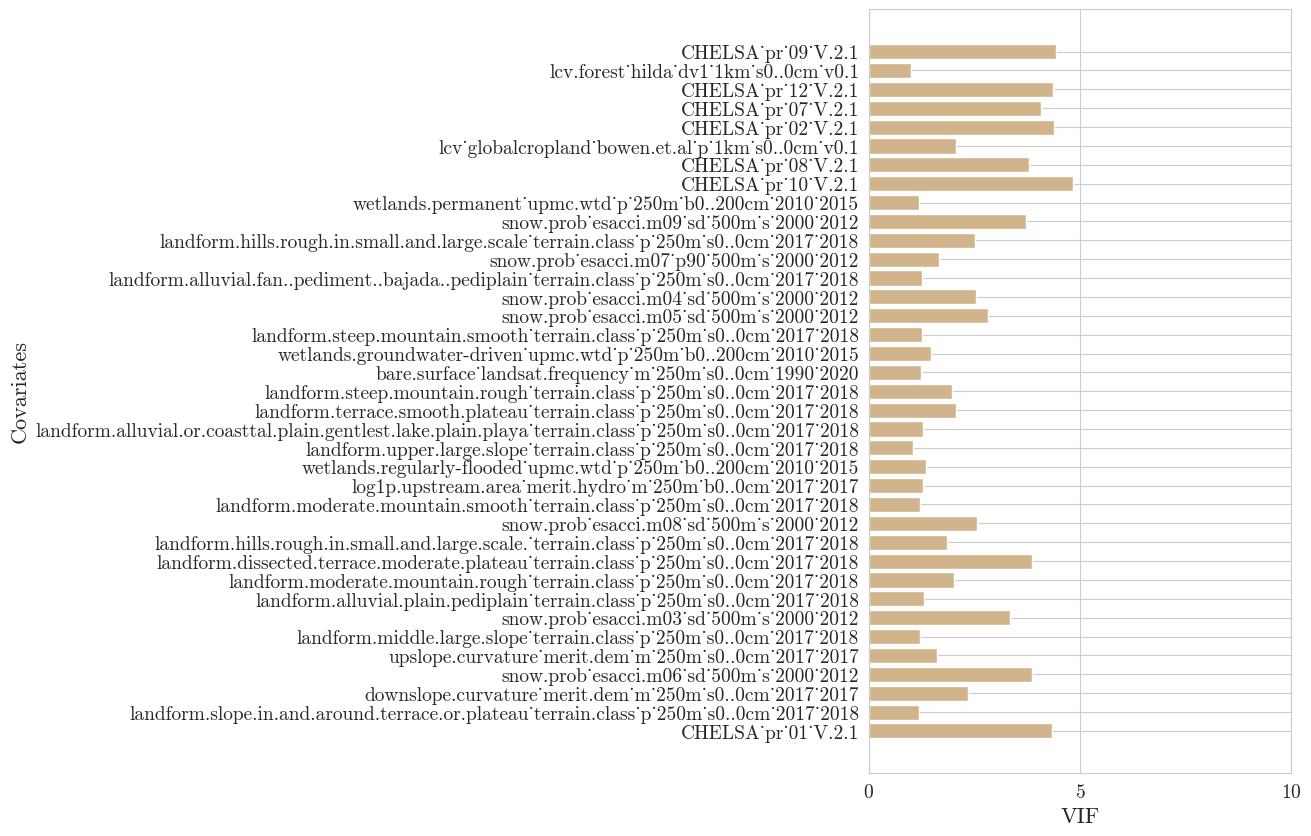

In [15]:
# Assuming `retained_variables_vif` is the DataFrame containing variables and their VIFs
variables = retained_variables_vif['Variable'].tolist()  # Extract variable names
vif_values = retained_variables_vif['VIF'].tolist()  # Extract VIF values

# Clean up variable names by removing patterns like "_{year}" and "_go_epsg.4326" and everything after
cleaned_variables = [
    re.sub(r"(_\{year\})|(_go_epsg\.4326.*)", "", var) for var in variables
]

# Adjust figure size to make the plot slightly larger
plt.figure(figsize=(14, len(cleaned_variables) * 0.25))  # Increase both width and height
plt.barh(cleaned_variables, vif_values, color='tan')  # Horizontal bar plot
plt.xlabel('VIF', fontsize=16)  # Increase font size for x-axis label
plt.ylabel('Covariates', fontsize=16)  # Increase font size for y-axis label
plt.gca().invert_yaxis()  # Invert y-axis to have the highest VIF on top
plt.xticks([0, 5, 10], fontsize=14)  # Increase font size for x-axis ticks
plt.yticks(fontsize=14)  # Increase font size for y-axis ticks
plt.tight_layout(pad=3)  # Adjust padding for better layout

# Save and display the plot
plt.savefig(os.path.join(plot_dir,'vif_selected_covariates3.png'), dpi=600)  # Save the plot as a file
plt.show()  # Display the plot


In [16]:
# Create a DataFrame from the column names
columns_df = pd.DataFrame(final_dataframe.columns, columns=['Column Names'])

# Export column names to CSV
columns_df.to_csv('outputs/supportive/VIF_selected_columns.csv', index=False)

In [17]:
# check of the dataframes have the same number of columns and the same column order
def same_columns(df1, df2):
    # Check if the number of columns is the same
    if len(df1.columns) != len(df2.columns):
        return False

    # Check if the column names and order are the same
    if list(df1.columns) != list(df2.columns):
        return False

    return True
def align_columns(df1, df2):
    """
    Align columns of df2 to match the order of df1's columns.
    If df2 is missing any columns from df1, those columns will be added with NaN values.
    """
    df2_aligned = df2.reindex(columns=df1.columns)
    return df2_aligned

# Assuming df1 and df2 are your two DataFrames
# Call the same_columns function to check if they have the same number of columns and same order
if same_columns(geo_train_data, geo_test_data):
    print("The two DataFrames have the same number of columns and the same column order.")
else:
    print("The two DataFrames do not have the same number of columns or the same column order.")
    geo_test_data_aligned = align_columns(geo_train_data, geo_test_data)
    print("The two dfs have been aligned as geo_test_data_aligned.")
    print(f"Dimensions of geo_test_data_aligned:{geo_test_data_aligned.shape}") 

The two DataFrames do not have the same number of columns or the same column order.
The two dfs have been aligned as geo_test_data_aligned.
Dimensions of geo_test_data_aligned:(772, 220)


In [18]:
print(geo_train_data.shape)
print(geo_test_data_aligned.shape)
# Check again if the two DataFrames have the same number of columns and the same column order
if same_columns(geo_train_data, geo_test_data_aligned):
    print("The two DataFrames have the same number of columns and the same column order.")
else:
    print("The two DataFrames do not have the same number of columns or the same column order.")

(1202, 220)
(772, 220)
The two DataFrames have the same number of columns and the same column order.


# Make a map

<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
C:\Users\giann\AppData\Local\Temp\ipykernel_43528\1556175239.py:31: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xticklabels([f'{abs(tick)}$^\circ$W' for tick in range(-170, -59, 10)], fontsize=12)
C:\Users\giann\AppData\Local\Temp\ipykernel_43528\1556175239.py:32: SyntaxWarning: invalid escape sequence '\c'
  ax.set_yticklabels([f'{tick}$^\circ$N' for tick in range(25, 76, 10)], fontsize=12)


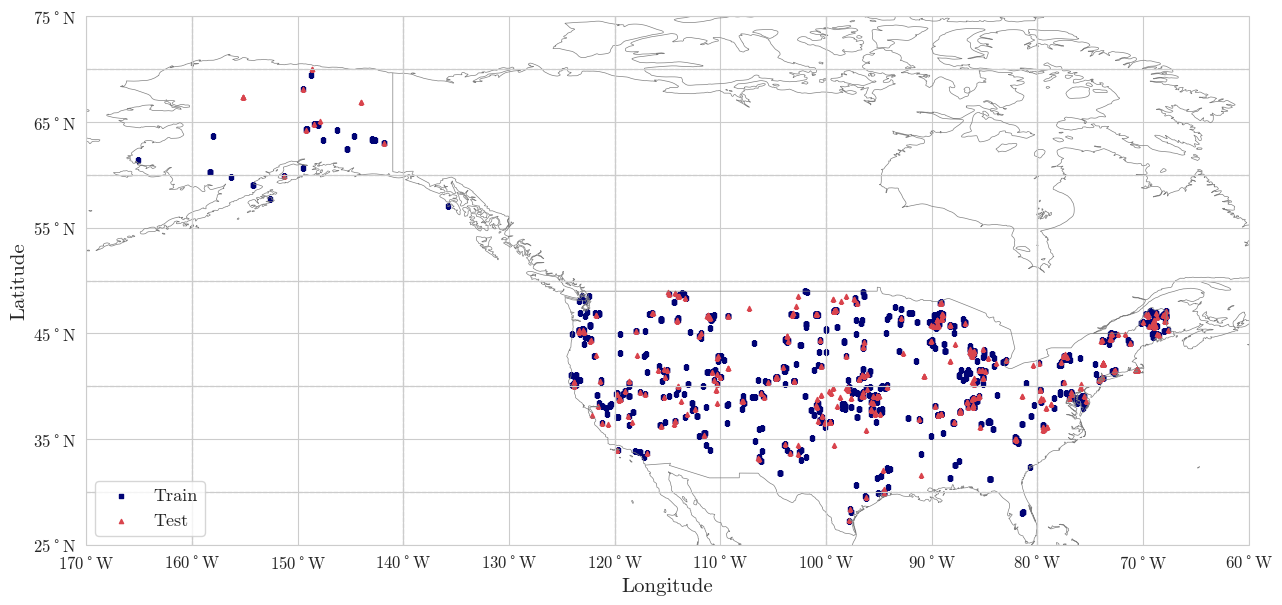

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a new figure and axis with PlateCarree projection
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot Train data
train_scatter = ax.scatter(geo_train_data['longitude.point_wgs84_dd'], geo_train_data['latitude.point_wgs84_dd'], s=9, color='#000375', marker='s', label='Train')

# Plot Test data
test_scatter = ax.scatter(geo_test_data['longitude.point_wgs84_dd'], geo_test_data['latitude.point_wgs84_dd'], s=9, color='#D9444D', marker='^', label='Test')

# Add basemap and borders
ax.add_feature(cfeature.COASTLINE, edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray', linewidth=0.5)
ax.gridlines(color='gray', linestyle='--')

# Set legend position
plt.legend(handles=[train_scatter, test_scatter], loc='lower left', fontsize=13)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)

# Show grid
ax.gridlines()
ax.set_xticks(range(-170, -59, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(25, 76, 10), crs=ccrs.PlateCarree())

# Set x and y axis tick labels with LaTeX formatting
ax.set_xticklabels([f'{abs(tick)}$^\circ$W' for tick in range(-170, -59, 10)], fontsize=12)
ax.set_yticklabels([f'{tick}$^\circ$N' for tick in range(25, 76, 10)], fontsize=12)

plt.autoscale(enable=False, axis='both', tight=True)

# Save the plot
plt.savefig(f'{plot_dir}/map.png')

# Show the plot
plt.show()

In [47]:
# Path to the shapefile zip file of states
zip_file = "ne_10m_admin_1_states_provinces.zip"

# If the zip file doesn't exist, extract its contents
if not os.path.exists("ne_10m_admin_1_states_provinces"):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()

# Load shapefile of states
states_shapefile_dir = "ne_10m_admin_1_states_provinces"
states_shapefile = gpd.read_file(states_shapefile_dir)

# Load train and test data
train_data = pd.read_csv("train_geocovariates.csv")
test_data = pd.read_csv("test_geocovariates.csv")

# Convert train and test data to GeoDataFrame
train_gdf = gpd.GeoDataFrame(train_data, geometry=gpd.points_from_xy(train_data['longitude.point_wgs84_dd'], train_data['latitude.point_wgs84_dd']))
test_gdf = gpd.GeoDataFrame(test_data, geometry=gpd.points_from_xy(test_data['longitude.point_wgs84_dd'], test_data['latitude.point_wgs84_dd']))

# Spatial join to get states for train and test data
train_states = gpd.sjoin(train_gdf, states_shapefile, op='within', how='left')
test_states = gpd.sjoin(test_gdf, states_shapefile, op='within', how='left')

# Count occurrences of each state in train and test datasets
train_state_counts = train_states['name'].value_counts().reset_index()
train_state_counts.columns = ['State', 'Train Samples']
test_state_counts = test_states['name'].value_counts().reset_index()
test_state_counts.columns = ['State', 'Test Samples']

# Print the number of samples for train set per state
print("Train Samples per State:")
print(train_state_counts)

# Print the number of samples for test set per state
print("\nTest Samples per State:")
print(test_state_counts)

FileNotFoundError: [Errno 2] No such file or directory: 'ne_10m_admin_1_states_provinces.zip'

In [25]:
# Extend train_state_counts with a new column "label" containing the value "Train"
train_state_counts = train_state_counts.assign(label='Train')

# Extend test_state_counts with a new column "label" containing the value "Test"
test_state_counts = test_state_counts.assign(label='Test')

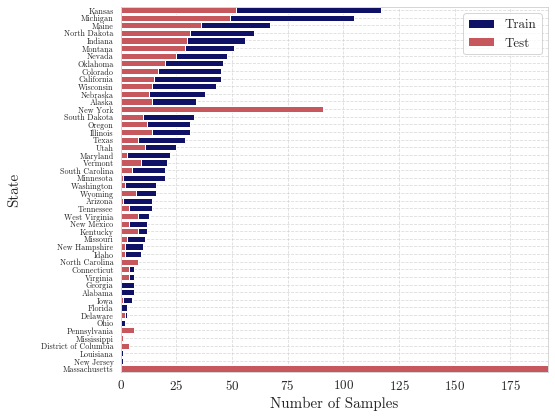

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Concatenate train and test dataframes to ensure all states are included
combined_state_counts = pd.merge(train_state_counts, test_state_counts, on='State', how='outer')

# Fill missing values with 0
combined_state_counts = combined_state_counts.fillna(0)

# Sort dataframe by train samples
combined_state_counts = combined_state_counts.sort_values(by='Train Samples', ascending=False)

# Set color palette
sns.set_palette(['#000375', '#D9444D'])

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot horizontal bar plot for combined_state_counts
sns.barplot(x='Train Samples', y='State', data=combined_state_counts, color='#000375', label='Train', ax=ax)
sns.barplot(x='Test Samples', y='State', data=combined_state_counts, color='#D9444D', label='Test', ax=ax)

# Remove title
plt.title('')

# Add x and y labels with font size 12
plt.xlabel('Number of Samples', fontsize=15)
plt.ylabel('State', fontsize=15, labelpad=20)  # Adjust labelpad to move the label further to the right
# Adjust labelpad to move the label further to the right
plt.yticks(fontsize=8)

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Display legend
plt.legend()

# Adjust layout parameters to ensure all labels are visible
plt.tight_layout()
plt.autoscale(enable=True, axis='both', tight=True)

# Save the plot
plt.savefig('outputs/plots/countries.png')

# Show the plot
plt.show()


# Step 2: Prepare the input data for the regression analysis
The selected covariates from the VIF will be used; while parameters like ID and coordinates have been removed from the analytics

In [20]:
# Select only the desired columns from geo_train_data and geo_test_data
geo_train_data = geo_train_data.loc[:, final_dataframe.columns]
geo_test_data = geo_test_data.loc[:, final_dataframe.columns]
# Print the number of columns in each dataset
print("Number of columns in geo_train_data:", len(geo_train_data.columns))
print("Number of columns in geo_test_data:", len(geo_test_data.columns))

print("Columns in geo_train_data_filtered:")
print(geo_train_data.columns)
print("\nColumns in geo_test_data_filtered:")
print(geo_test_data.columns)

Number of columns in geo_train_data: 37
Number of columns in geo_test_data: 37
Columns in geo_train_data_filtered:
Index(['CHELSA_pr_09_{year}_V.2.1',
       'lcv.forest_hilda_dv1_1km_s0..0cm_{year}_v0.1',
       'CHELSA_pr_12_{year}_V.2.1', 'CHELSA_pr_07_{year}_V.2.1',
       'CHELSA_pr_02_{year}_V.2.1',
       'lcv_globalcropland_bowen.et.al_p_1km_s0..0cm_{year}_v0.1',
       'CHELSA_pr_08_{year}_V.2.1', 'CHELSA_pr_10_{year}_V.2.1',
       'wetlands.permanent_upmc.wtd_p_250m_b0..200cm_2010_2015_go_epsg.4326_v20231002',
       'snow.prob_esacci.m09_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
       'landform.hills.rough.in.small.and.large.scale_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002',
       'snow.prob_esacci.m07_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
       'landform.alluvial.fan..pediment..bajada..pediplain_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002',
       'snow.prob_esacci.m04_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
       's

In [21]:
# keep only the spectra
print("Training Spectra:")
print(spec_train_data.head(3)) 
train_X = spec_train_data.iloc[:,2:].values.astype(float) #Skipping the first two columns with sample id and SOC
test_X = spec_test_data.iloc[:,2:].values.astype(float)   #Skipping the first two columns with sample id and SOC
# keep the dependent variable
train_y = spec_train_data.iloc[:,1].values.astype(float) #Keeping only the second with SOC
test_y = spec_test_data.iloc[:,1].values.astype(float)   #Keeping only the second column with SOC

Training Spectra:
  sample_id  soc_perc_log1p     1350     1352     1354     1356     1358  \
0    S11580         0.41871  0.24450  0.24451  0.24439  0.24411  0.24366   
1    S56448         0.13976  0.62000  0.61932  0.61860  0.61787  0.61715   
2    S44770         0.94001  0.55591  0.55676  0.55751  0.55814  0.55867   

      1360     1362     1364  ...     2532     2534     2536     2538  \
0  0.24311  0.24256  0.24209  ...  0.13869  0.13821  0.13773  0.13724   
1  0.61647  0.61586  0.61535  ...  0.39450  0.39372  0.39292  0.39209   
2  0.55914  0.55962  0.56015  ...  0.55878  0.55823  0.55769  0.55716   

      2540     2542     2544     2546     2548     2550  
0  0.13674  0.13624  0.13573  0.13521  0.13469  0.13416  
1  0.39123  0.39033  0.38939  0.38840  0.38736  0.38624  
2  0.55664  0.55612  0.55562  0.55512  0.55463  0.55414  

[3 rows x 603 columns]


## Hyperparameters Optimization for CNN as feature extractor 

### Find the best hyperparameters

In [22]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Define the search space
space = {
    'lr': hp.choice('lr', [0.0001, 0.001]),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'filters_1': hp.choice('filters_1', [48, 64, 128]),
    'kernel_size_1': hp.choice('kernel_size_1', [7, 9]),
    'filters_2': hp.choice('filters_2', [16, 32]),
    'kernel_size_2': hp.choice('kernel_size_2', [5, 7]),
    'filters_3': hp.choice('filters_3', [8, 16]),
    'kernel_size_3': hp.choice('kernel_size_3', [3, 5]),
    'pooling_1': hp.choice('pooling_1', [True, False]),
    'pooling_2': hp.choice('pooling_2', [True, False]),
}

# Define the function to optimize
def objective(params):
    # Build the model
    model = Sequential()
    model.add(Conv1D(params['filters_1'], params['kernel_size_1'], activation="relu", input_shape=(601, 1)))
    if params['pooling_1']:
        model.add(MaxPooling1D(2))
    model.add(Conv1D(params['filters_2'], params['kernel_size_2'], activation="relu"))
    if params['pooling_2']:
        model.add(MaxPooling1D(2))
    model.add(Conv1D(params['filters_3'], params['kernel_size_3'], activation="relu"))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="linear"))
    
    # Set the learning rate
    optimizer = Adam(learning_rate=params['lr'])
    
    # Compile the model
    model.compile(loss="mse", optimizer=optimizer, metrics=['mse'])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    # Train the model with the given parameters
    history = model.fit(train_X, train_y, epochs=100, batch_size=params['batch_size'],
                        validation_data=(test_X, test_y), callbacks=[early_stopping], verbose=0)

    # Evaluate model
    _, mse = model.evaluate(test_X, test_y, verbose=0)

    return mse  # Return validation MSE

# Define the trials object
trials = Trials()

# Optimize using TPE algorithm
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=80,  # Adjust as needed
            trials=trials)

# Map the indices back to the original values
best_lr = [0.0001, 0.001][best['lr']]
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_filters_1 = [48, 64, 128][best['filters_1']]
best_kernel_size_1 = [7, 9][best['kernel_size_1']]
best_filters_2 = [16, 32][best['filters_2']]
best_kernel_size_2 = [5, 7][best['kernel_size_2']]
best_filters_3 = [8, 16][best['filters_3']]
best_kernel_size_3 = [3, 5][best['kernel_size_3']]
best_pooling_1 = [True, False][best['pooling_1']]
best_pooling_2 = [True, False][best['pooling_2']]

print("Best learning rate:", best_lr)
print("Best batch size:", best_batch_size)
print("Best number of filters for Conv1D layer 1:", best_filters_1)
print("Best kernel size for Conv1D layer 1:", best_kernel_size_1)
print("Best number of filters for Conv1D layer 2:", best_filters_2)
print("Best kernel size for Conv1D layer 2:", best_kernel_size_2)
print("Best number of filters for Conv1D layer 3:", best_filters_3)
print("Best kernel size for Conv1D layer 3:", best_kernel_size_3)
print("Best use of MaxPooling1D after Conv1D layer 1:", best_pooling_1)
print("Best use of MaxPooling1D after Conv1D layer 2:", best_pooling_2)

  0%|                                                                           | 0/80 [00:00<?, ?trial/s, best loss=?]

C:\Users\giann\anaconda3\envs\fedler_new\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████████████████████████████████████████| 80/80 [1:11:41<00:00, 53.77s/trial, best loss: 0.1003149151802063]
Best learning rate: 0.001
Best batch size: 32
Best number of filters for Conv1D layer 1: 64
Best kernel size for Conv1D layer 1: 7
Best number of filters for Conv1D layer 2: 32
Best kernel size for Conv1D layer 2: 5
Best number of filters for Conv1D layer 3: 8
Best kernel size for Conv1D layer 3: 3
Best use of MaxPooling1D after Conv1D layer 1: False
Best use of MaxPooling1D after Conv1D layer 2: True


### Train the CNN model based on the best hyperparameters for Regression Task

In [23]:
# Define functions for RMSE and RPIQ
def RMSE(obs, pred):
    return sqrt(mean_squared_error(obs, pred))

def RPIQ(obs, pred):
    return iqr(obs) / RMSE(obs, pred)

In [46]:
checkpoints_dir = os.path.join(output_dir,'checkpoints')
os.makedirs(checkpoints_dir, exist_ok=True)

# Define the optimizer 
optimizer = Adam(learning_rate=best_lr)

# Build the best model with the obtained hyperparameters
best_model = Sequential()
best_model.add(Conv1D(best_filters_1, best_kernel_size_1, activation="relu", input_shape=(601, 1)))
if best_pooling_1:
    best_model.add(MaxPooling1D(2))
best_model.add(Conv1D(best_filters_2, best_kernel_size_2, activation="relu"))
if best_pooling_2:
    best_model.add(MaxPooling1D(2))
best_model.add(Conv1D(best_filters_3, best_kernel_size_3, activation="relu"))
best_model.add(MaxPooling1D(2))
best_model.add(Flatten())
best_model.add(Dense(128, activation="relu"))
best_model.add(Dense(1, activation="linear"))
best_model.compile(loss="mse", optimizer=optimizer, metrics=['mse'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
cnn_model_checkpoint = ModelCheckpoint(filepath=f'{checkpoints_dir}/best_model.h5', monitor='val_loss', save_best_only=True)

# Train the best model
history = best_model.fit(
    train_X, 
    train_y, 
    epochs=500, 
    batch_size=best_batch_size,
    validation_data=(test_X, test_y), 
     callbacks=[early_stopping, cnn_model_checkpoint],
    verbose=0
)

# Check if early stopping kept the best points
cnn_best_val_loss = min(history.history['val_loss'])
cnn_best_val_loss_epoch = history.history['val_loss'].index(cnn_best_val_loss) + 1
print("Best validation loss:", cnn_best_val_loss)
print("Epoch when best validation loss occurred:", cnn_best_val_loss_epoch)

# Make predictions
y_pred = best_model.predict(test_X)

# Reshape y_pred to match the expected dimensions
y_pred_cnn1D = y_pred.reshape(-1)

# Calculate R-squared
r2 = r2_score(test_y, y_pred_cnn1D)

# Calculate RMSE
rmse = RMSE(test_y, y_pred_cnn1D)

# Calculate RPIQ
rpiq = RPIQ(test_y, y_pred_cnn1D)

print("R-squared (R2):", r2)
print("Root Mean Squared Error (RMSE):", rmse)
print("Relative Prediction Interval Quality (RPIQ):", rpiq)
print(f"Best model (epoch with minimum loss) saved as {checkpoints_dir}/best_model.h5")

Best validation loss: 0.10031405836343765
Epoch when best validation loss occurred: 157
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
R-squared (R2): 0.6075019475530493
Root Mean Squared Error (RMSE): 0.31672394506046997
Relative Prediction Interval Quality (RPIQ): 1.8443269260506132
Best model (epoch with minimum loss) saved as outputs\checkpoints/best_model.h5


In [52]:
predictions_dir = os.path.join(output_dir, 'predictions')
os.makedirs(predictions_dir, exist_ok=True)
# Create a DataFrame for predictions
predictions_df = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred_cnn1D})

# Save the predictions to a CSV file
predictions_df.to_csv(os.path.join(predictions_dir, "retained_variables_vif.csv"), index=False)

In [53]:
def plot_regression(test_y, y_pred, model_name, filename=None):
    
    # Create plot
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Calculate the point density
    xy = np.vstack([test_y, y_pred])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density
    idx = z.argsort()
    test_y, y_pred, z = test_y[idx], y_pred[idx], z[idx]

    # Create a custom colormap
    custom_colors = ['#000375', '#D9444D', '#F5E8C5']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors, N=200)

    # Create the scatter plot
    ax_ = ax.scatter(test_y, y_pred, c=z, cmap=cmap, s=20)

    # Add least squares regression line
    sns.regplot(x=test_y, y=y_pred, scatter=False, line_kws={'color':'#27847A', 'linewidth':2}, ax=ax)

    # Add 1:1 line
    ax.plot(test_y, test_y, linestyle='--', color='black')

    # Add colorbar
    plt.colorbar(ax_, label='Density')

    # Set font to Computer Modern Serif
    plt.rcParams['font.family'] = 'serif'

    # Add labels and title with updated font sizes
    plt.xlabel('Observed', fontsize=22)
    plt.ylabel('Predicted', fontsize=22)
    plt.title(model_name, fontsize=22)

    # Calculate and add R2, RMSE, and RPIQ annotations
    r2 = r2_score(test_y, y_pred)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred))
    rpiq = RPIQ(test_y, y_pred)
    ax.text(ax.get_xlim()[0] + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
            ax.get_ylim()[1] - 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
            f'\nR$^2$: {r2:.2f}\nRMSE: {rmse:.2f}\nRPIQ: {rpiq:.2f}',
            verticalalignment='top', horizontalalignment='left', fontsize=16, style='italic', fontname='serif')

    # Set y-axis tick formatter to remove decimals
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Adjust y-axis ticks to have a step of 1
    plt.yticks(np.arange(0, 5, 1), fontsize=20)
    plt.xticks(fontsize=20)

    # Remove frame around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save the plot if filename is provided
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.grid(True)

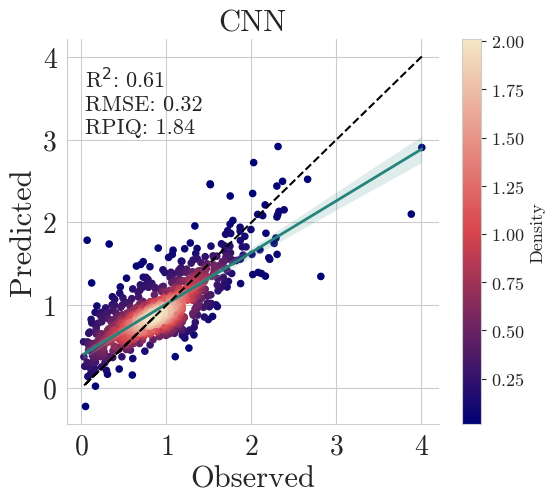

In [54]:
plot_regression(test_y,  predictions_df['Predicted'], "CNN", os.path.join(plot_dir, "CNN1D_spectral_plot.png"))

#### Save the obtained hyperparameters in `TPE_selected-hyperparameters.csv`

In [55]:
# Define the file path for saving the hyperparameters
hyperparameters_file = os.path.join(supp_dir, 'TPE_selected-hyperparameters.csv')
# Define the hyperparameters to save
hyperparameters = {
    'Learning Rate': best_lr,
    'Batch Size': best_batch_size,
    'Filters 1': best_filters_1,
    'Kernel Size 1': best_kernel_size_1,
    'Filters 2': best_filters_2,
    'Kernel Size 2': best_kernel_size_2,
    'Filters 3': best_filters_3,
    'Kernel Size 3': best_kernel_size_3,
    'Pooling 1': best_pooling_1,
    'Pooling 2': best_pooling_2
}
# Write the hyperparameters to the CSV file
with open(hyperparameters_file, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=hyperparameters.keys())
    writer.writeheader()
    writer.writerow(hyperparameters)

## Load CNN model based on the obtained best hyperparameters as feature generator

In [67]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError as MSE

cnn_model_reg = load_model(f'{checkpoints_dir}/best_model.h5',
                   custom_objects={'mse': MSE(), 'mean_squared_error': MeanSquaredError()})
cnn_model_reg.summary()


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_249 (Conv1D)                  │ (None, 595, 64)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_250 (Conv1D)                  │ (None, 591, 32)             │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_145 (MaxPooling1D)     │ (None, 295, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_251 (Conv1D)                  │ (None, 293, 8)              │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_146 (MaxPooling1D)     │ (None, 146, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_83 (Flatten)                 │ (None, 1168)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_164 (Dense)                    │ (None, 128)                 │         149,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,323 (630.17 KB)

 Trainable params: 161,321 (630.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [68]:
from tensorflow.keras.models import Model

# Rebuild the model using functional API (grab input from first layer)
x = cnn_model_reg.layers[0].input
for layer in cnn_model_reg.layers[:-1]:  # skip the last Dense(1) layer
    x = layer(x)

# Now define the feature extractor model
cnn_model= Model(inputs=cnn_model_reg.layers[0].input, outputs=x)

# Check the summary
cnn_model.summary()



Model: "functional_707"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_83 (InputLayer)          │ (None, 601, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_249 (Conv1D)                  │ (None, 595, 64)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_250 (Conv1D)                  │ (None, 591, 32)             │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_145 (MaxPooling1D)     │ (None, 295, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_251 (Conv1D)                  │ (None, 293, 8)              │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_146 (MaxPooling1D)     │ (None, 146, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_83 (Flatten)                 │ (None, 1168)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_164 (Dense)                    │ (None, 128)                 │         149,632 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,192 (629.66 KB)

 Trainable params: 161,192 (629.66 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Generate features using the trained CNN model
X_train_features = cnn_model.predict(train_X)
X_test_features = cnn_model.predict(test_X)

# Access the underlying NumPy array and reshape it
reshaped_array = geo_train_data.to_numpy().reshape(geo_train_data.shape[0], geo_train_data.shape[1])
reshaped_array2 = geo_test_data.to_numpy().reshape(geo_test_data.shape[0], geo_test_data.shape[1])

# Create a new DataFrame with the reshaped array
X_train_geo = pd.DataFrame(reshaped_array, index=geo_train_data.index, columns=geo_train_data.columns[:geo_train_data.shape[1]])
test_X_geo = pd.DataFrame(reshaped_array2, index=geo_test_data.index, columns=geo_test_data.columns[:geo_test_data.shape[1]])

print('Geocovariates train data shape:', X_train_geo.shape)
print('Geocovariates test data shape:', test_X_geo.shape)

# Train the second model (Random Forest for diverse data and CNN features)
X_train_combined = np.concatenate((X_train_features, X_train_geo), axis=1)
X_test_combined = np.concatenate((X_test_features, geo_test_data), axis=1)
print('Combined train data shape:', X_train_combined.shape)
print('Combined test data shape:', X_test_combined.shape)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Geocovariates train data shape: (1202, 37)
Geocovariates test data shape: (772, 37)
Combined train data shape: (1202, 165)
Combined test data shape: (772, 165)


## Hyperparameter optimization for XGBoost (as head for the Regression Task)

In [72]:
# Define the parameter grid for hyperparameter optimization
param_grid_xgb = {
    'max_depth': list(range(3, 9)),  # Maximum depth of a tree
    'learning_rate': [0.02, 0.05, 0.1, 0.2, 0.3],  # Learning rate
    'n_estimators': [10, 50, 100, 200, 500],  # Number of trees
    'subsample': [0.3, 0.5, 0.8],  # Subsample ratio of columns
    'reg_alpha': [0, 5, 10]  # L1 regularization term on weights
}
# Initialize the XGBoost regressor
model_cnnxgb = XGBRegressor(random_state=seed)

# Perform Bayesian optimization with cross-validation
bayes_search_cnnxgb = BayesSearchCV(estimator=model_cnnxgb, search_spaces=param_grid_xgb, n_iter=200, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=seed)

# Track progress with tqdm
with tqdm(total=100, desc='XGBoost Progress') as pbar:
    bayes_search_cnnxgb.fit(X_train_combined, train_y)
    pbar.update(50)

# Get the best model from the Bayesian search
best_model_cnnxgb = bayes_search_cnnxgb.best_estimator_

# Evaluate the best model on the test set
y_pred_cnnxgb = best_model_cnnxgb.predict(X_test_combined)

# Print he best hyperparameters
best_params_xgb = best_model_cnnxgb.get_params()
print("\nBest Hyperparameters for XGBoost:")
for param_name, param_value in best_params_xgb.items():
    print(f"{param_name}: {param_value}")

XGBoost Progress:  50%|███████████████████████████████▌                               | 50/100 [50:09<50:09, 60.18s/it]


Best Hyperparameters for XGBoost:
objective: reg:squarederror
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
feature_weights: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.02
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 6
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 500
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: 0
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: 0.5
tree_method: None
validate_parameters: None
verbosity: None


In [73]:
# Print best hyperparameters for XGBoost
print("Best hyperparameters for XGBoost:")
print(bayes_search_cnnxgb.best_params_)

Best hyperparameters for XGBoost:
OrderedDict({'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 500, 'reg_alpha': 0, 'subsample': 0.5})


In [74]:
# Create DataFrame with the best hyperparameters
xgb_hyperparameters_df = pd.DataFrame(bayes_search_cnnxgb.best_params_, index=[0])
# Save DataFrame to CSV file
xgb_hyperparameters_df.to_csv(f'{supp_dir}/hyperparameters_hybrid_xgb.csv', index=False)
print(f"XGBoost hyperparameters saved as '{supp_dir}/hyperparameters_hybrid_xgb.csv'")

XGBoost hyperparameters saved as 'outputs\supportive/hyperparameters_hybrid_xgb.csv'


In [76]:
# Create an empty DataFrame to store model results
results_df = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'RPIQ', 'Hyperparameters'])

# Calculate metrics for XGBoost
r2_cnnxgb = r2_score(test_y, y_pred_cnnxgb)
rmse_cnnxgb = np.sqrt(mean_squared_error(test_y, y_pred_cnnxgb))
rpiq_cnnxgb = RPIQ(test_y, y_pred_cnnxgb)
hyperparams_cnnxgb = bayes_search_cnnxgb.best_params_
results_df.loc[len(results_df)] = ['XGBoost', r2_cnnxgb, rmse_cnnxgb, rpiq_cnnxgb, hyperparams_cnnxgb]
# Display the results DataFrame
print(results_df)
# Save the DataFrame to a CSV file
results_df.to_csv(f'{output_dir}/cnn-ml_results.csv', index=False)

     Model        R2      RMSE      RPIQ  \
0  XGBoost  0.629391  0.307766  1.898011   

                                     Hyperparameters  
0  {'learning_rate': 0.02, 'max_depth': 6, 'n_est...  


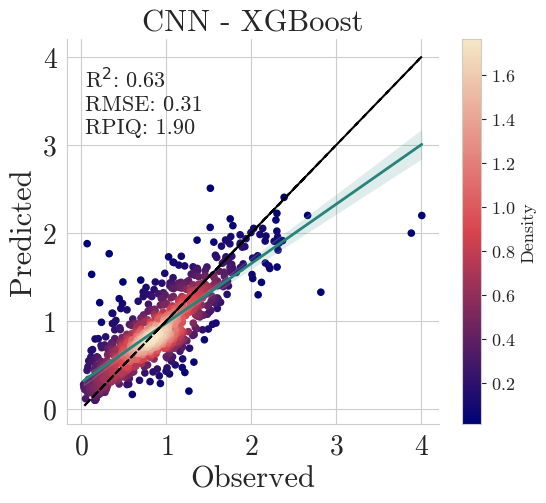

In [78]:
# Calculate and ave regression plot
plot_regression(test_y, y_pred_cnnxgb, "CNN - XGBoost", f"{plot_dir}/cnn_xgboost_plot.png")

In [80]:
# Create DataFrames for actual and predicted values of XGBoost
xgb_predictions_df = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred_cnnxgb})

# Define the folder to save predictions
predictions_dir = f"{output_dir}/predictions"
os.makedirs(predictions_dir, exist_ok=True)
# Save XGBoost predictions to CSV
xgb_predictions_path = f"{predictions_dir}/xgboost_hybrid_predictions.csv"
xgb_predictions_df.to_csv(xgb_predictions_path, index=False)

In [81]:
# Save XGBoost model as pickle file under checkpoints_dir
xgb_model_path = f"{checkpoints_dir}/hybrid_xgboost_model.pkl"
dump(best_model_cnnxgb, xgb_model_path)
print(f"XGBoost model saved successfully as {xgb_model_path}.")

XGBoost model saved successfully as outputs\checkpoints/hybrid_xgboost_model.pkl.
